In [2]:
%reset
%pylab inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.insert(0, '/home/knight/matar/PYTHON/ECOGpy/')


In [4]:
from __future__ import division
import pandas as pd
import os
from utils import loadmat
import scipy.ndimage as ndimage
import matplotlib.ticker as ticker

In [5]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)


In [8]:
savedir = '/home/knight/matar/NHB_submission_2017'
savefig = False

In [21]:
ridx

11171

In [23]:
patterns = ['S','R','SR','D']

p = patterns[2]
cdata_all = np.empty((25000, 3500))
RTs_all, offsets_all = [np.empty(25000) for i in range(2)]
cdata_all[:] = np.nan
RTs_all[:] = np.nan
offsets_all[:] = np.nan
subjs_all, tasks_all = [pd.DataFrame() for i in range(2)]

for i in df.groupby(['subj','task']):
    subj, task = i[0]
    filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat.loadmat(filename)
    data = data_dict['data_zscore']
    active_elecs = data_dict['active_elecs']
    RTs = data_dict['RTs']
    try:
        offsets = data_dict['offsets_stim'] - data_dict['onsets_stim'] #relative stim offsets relative to stim onset
    except KeyError:
        print('{0} {1} missing offests_stim'.format(subj, task))
        continue
    elecs = list(i[1][i[1].pattern == p].elec)

    if len(elecs)>0: #the pattern exists
        eidx = np.in1d(active_elecs, elecs)
        
        datastack = np.vstack(data[eidx,:,:])
        ridx = np.where(np.isnan(cdata_all)[:,0])[0][0]
        datastack = datastack[:,:3500]
        cdata_all[ridx:ridx+datastack.shape[0],:datastack.shape[1]] = datastack
        
        RTs_all[ridx:ridx+datastack.shape[0]] = np.tile(RTs, sum(eidx))
        offsets_all[ridx:ridx+datastack.shape[0]] = np.tile(offsets, sum(eidx))

        subjs_all = subjs_all.append(pd.DataFrame(np.tile(subj, sum(eidx)*len(RTs)), index = np.tile(RTs, sum(eidx))))
        tasks_all = tasks_all.append(pd.DataFrame(np.tile(task, sum(eidx)*len(RTs)), index = np.tile(RTs, sum(eidx))))

        
#sort all trials by RT
sortind = RTs_all.argsort()
cdata_all = cdata_all[sortind,:]
RTs_all = RTs_all[sortind]
offsets_all = offsets_all[sortind]
# RTs_all, offsets_all = [i[sortind] for i in [RTs_all, offsets_all]]
all_subjs = np.array(subjs_all.sort_index(inplace = False).squeeze())
all_tasks = np.array(tasks_all.sort_index(inplace = False).squeeze())

#remove extra rows
cdata_all = cdata_all[~np.isnan(cdata_all).all(axis=1)]
cdata_all[np.isnan(cdata_all)] = 0
RTs_all, offsets_all = [i[~np.isnan(i)] for i in [RTs_all, offsets_all]]
print('done')

CP7 DecisionAud missing offests_stim
CP9 DecisionAud missing offests_stim
ST27 DecisionVis missing offests_stim
ST32 DecisionVis missing offests_stim
done


In [29]:
min(RTs_all)

616.0

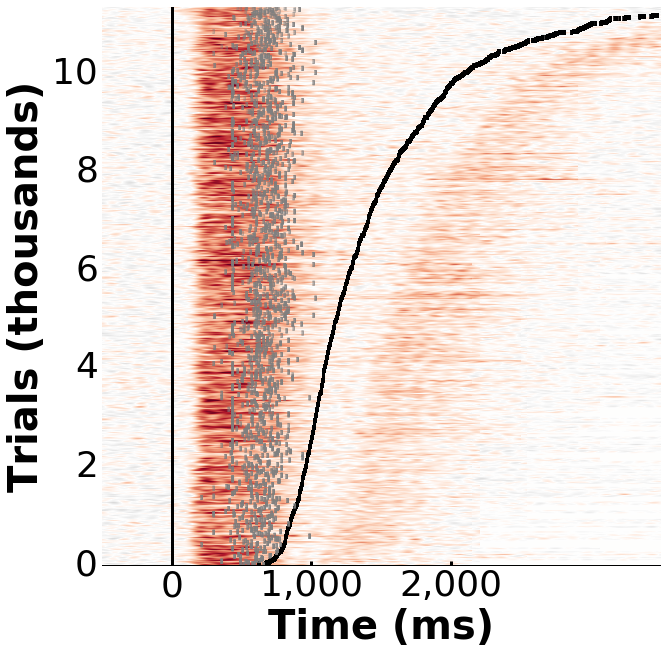

In [27]:
#plot single trial
f,ax = plt.subplots(figsize = (10, 10))
cm = plt.get_cmap('RdGy_r')

ax.autoscale(enable = True, tight = True)
ax.patch.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.xaxis.set_tick_params(labelsize = 36, width = 3)
ax.yaxis.set_tick_params(labelsize = 36, width = 0)
ax.set_xticks(np.arange(0, 3000, 1000))
ax.axvline(x = 0, lw = 3, color = 'black')
ax.set_ylabel('Trials (thousands)', fontsize = 40, weight = 'bold')
ax.set_xlabel('Time (ms)', fontsize = 40, weight = 'bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.0f')%(y*1e-3)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

v_val=.5
h_val=.15
verts = list(zip([-h_val,h_val,h_val,-h_val],[-v_val,-v_val,v_val,v_val]))
ax.scatter(RTs_all, range(len(RTs_all)), zorder=1, color='black', marker=(verts,0))
ax.scatter(offsets_all, range(len(offsets_all)), zorder=1, color='gray', alpha=.2, marker=(verts,0), edgecolor=None)

img = ndimage.gaussian_filter1d(cdata_all, axis = 0, sigma = 10, order=0) #gaussian smooth trials
cax = ax.imshow(img, aspect = 'auto', origin = 'lower', extent = (-500, img.shape[1], 0, len(RTs_all)), cmap = cm)

cax.set_clim(vmin=-3,vmax=3)

if savefig:
    filename= os.path.join(savedir, 'Fig2_SingleTrials_{0}.png'.format(p))
    plt.savefig(filename, bbox_inches = 'tight', dpi = 150, transparent = True)
    print filename